# RAPIDS cuML 
## Performance, Boundaries, and Correctness Benchmarks

**Description:** This notebook provides a simple and unified means of benchmarking single GPU cuML algorithms against their skLearn counterparts with the `cuml.benchmark` package in RAPIDS cuML. This enables quick and simple measurements of performance, validation of correctness, and investigation of upper bounds.

Each benchmark returns a Pandas `DataFrame` with the results. At the end of the notebook, these results are used to draw charts and output to a CSV file. 

Please refer to the [table of contents](#table_of_contents) for algorithms available to be benchmarked with this notebook.

In [1]:
!apt-get update && apt-get install -y gcc

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1581 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [498 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy InRelease [270 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [1134 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [998 kB]
Get:7 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1014 kB]
Get:8 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [44.0 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]        
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy/multiverse amd64 Packages [266 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy/restricted amd64 Package

In [2]:
import cuml
import pandas as pd

from cuml.benchmark.runners import SpeedupComparisonRunner
from cuml.benchmark.algorithms import algorithm_by_name

import warnings
warnings.filterwarnings('ignore', 'Expected column ')

print(cuml.__version__)

/opt/conda/envs/rapids/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/conda/envs/rapids/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/conda/envs/rapids/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWa

23.06.00


/opt/conda/envs/rapids/lib/python3.10/site-packages/umap/umap_.py:660: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()


In [3]:
N_REPS = 3  # Number of times each test is repeated

DATA_NEIGHBORHOODS = "blobs"
DATA_CLASSIFICATION = "classification"
DATA_REGRESSION = "regression"

INPUT_TYPE = "numpy"

benchmark_results = []

In [4]:
SMALL_ROW_SIZES = [2**x for x in range(14, 17)]
LARGE_ROW_SIZES = [2**x for x in range(18, 24, 2)]

SKINNY_FEATURES = [32, 256]
WIDE_FEATURES = [1000, 10000]

VERBOSE=True
RUN_CPU=True

In [5]:
def enrich_result(algorithm, runner, result):
    result["algo"] = algorithm
    result["dataset_name"] = runner.dataset_name
    result["input_type"] = runner.input_type
    return result

def execute_benchmark(algorithm, runner, verbose=VERBOSE, run_cpu=RUN_CPU, **kwargs):
    results = runner.run(algorithm_by_name(algorithm), verbose=verbose, run_cpu=run_cpu, **kwargs)
    results = [enrich_result(algorithm, runner, result) for result in results]
    benchmark_results.extend(results)

## Table of Contents<a id="table_of_contents"/>

### Benchmarks
1. [Neighbors](#neighbors)<br>
    1.1 [Nearest Neighbors - Brute Force](#nn_bruteforce)<br>
    1.2 [KNeighborsClassifier](#kneighborsclassifier)<br>
    1.3 [KNeighborsRegressor](#kneighborsregressor)<br>
2. [Clustering](#clustering)<br>
    2.1 [DBSCAN - Brute Force](#dbscan_bruteforce)<br>
    2.2 [K-Means](#kmeans)<br>
3. [Manifold Learning](#manifold_learning)<br>
    3.1 [UMAP - Unsupervised](#umap_unsupervised)<br>
    3.2 [UMAP - Supervised](#umap_supervised)<br>
    3.3 [T-SNE](#tsne)
4. [Linear Models](#linear_models)<br>
    4.1 [Linear Regression](#linear_regression)<br>
    4.2 [Logistic Regression](#logistic_regression)<br>
    4.3 [Ridge Regression](#ridge_regression)<br>
    4.4 [Lasso Regression](#lasso_regression)<br>
    4.5 [ElasticNet Regression](#elasticnet_regression)<br>
    4.6 [Mini-batch SGD Classifier](#minibatch_sgd_classifier)
5. [Decomposition](#decomposition)<br>
    5.1 [PCA](#pca)<br>
    5.2 [Truncated SVD](#truncated_svd)<br>
6. [Ensemble](#ensemble)<br>
    6.1 [Random Forest Classifier](#random_forest_classifier)<br>
    6.2 [Random Forest Regressor](#random_forest_regressor)<br>
    6.3 [FIL](#fil)<br>
    6.4 [Sparse FIL](#sparse_fil)<br>
7. [Random Projection](#random_projection)<br>
    7.1 [Gaussian Random Projection](#gaussian_random_projection)<br>
    7.2 [Sparse Random Projection](#sparse_random_projection)<br>
8. [SVM](#svm)<br>
    8.1 [SVC - Linear Kernel](#svc_linear_kernel)<br>
    8.2 [SVC - RBF Kernel](#svc_rbf_kernel)<br>
    8.3 [SVR - Linear Kernel](#svr_linear_kernel)<br>
    8.4 [SVR - RBF Kernel](#svr_rbf_kernel)<br>
    
### Chart & Store Results
9. [Convert to Pandas DataFrame](#convert_to_pandas)<br>
10. [Chart Results](#chart_results)<br>
11. [Output to CSV](#output_csv)<br>

## Neighbors<a id="neighbors"/>


### Nearest Neighbors - Brute Force<a id="nn_bruteforce"/>

In [6]:
runner = cuml.benchmark.runners.SpeedupComparisonRunner(
    bench_rows=SMALL_ROW_SIZES, 
    bench_dims=SKINNY_FEATURES,
    dataset_name=DATA_NEIGHBORHOODS,
    input_type=INPUT_TYPE,
    n_reps=N_REPS,
)

execute_benchmark("NearestNeighbors", runner)

NearestNeighbors (n_samples=16384, n_features=32) [cpu=0.24378156661987305, gpu=0.02150893211364746, speedup=11.333968852186443]
NearestNeighbors (n_samples=16384, n_features=256) [cpu=0.3639814853668213, gpu=0.0464625358581543, speedup=7.833870421494473]
NearestNeighbors (n_samples=32768, n_features=32) [cpu=0.7414793968200684, gpu=0.03950667381286621, speedup=18.768459231275234]
NearestNeighbors (n_samples=32768, n_features=256) [cpu=1.1183443069458008, gpu=0.10695362091064453, speedup=10.456348250987526]
NearestNeighbors (n_samples=65536, n_features=32) [cpu=0.9169487953186035, gpu=0.10298395156860352, speedup=8.903802790163585]
NearestNeighbors (n_samples=65536, n_features=256) [cpu=2.381298780441284, gpu=0.37604451179504395, speedup=6.332491781555814]


### KNeighborsClassifier<a id="kneighborsclassifier"/>

In [7]:
runner = cuml.benchmark.runners.SpeedupComparisonRunner(
    bench_rows=SMALL_ROW_SIZES, 
    bench_dims=SKINNY_FEATURES,
    dataset_name=DATA_CLASSIFICATION,
    input_type=INPUT_TYPE,
    n_reps=N_REPS
)

execute_benchmark("KNeighborsClassifier", runner)

KNeighborsClassifier (n_samples=16384, n_features=32) [cpu=0.001279592514038086, gpu=0.0024919509887695312, speedup=0.5134902411021814]
KNeighborsClassifier (n_samples=16384, n_features=256) [cpu=0.0022852420806884766, gpu=0.006440162658691406, speedup=0.35484229231452685]
KNeighborsClassifier (n_samples=32768, n_features=32) [cpu=0.0020818710327148438, gpu=0.0028727054595947266, speedup=0.7247074446012117]
KNeighborsClassifier (n_samples=32768, n_features=256) [cpu=0.004659414291381836, gpu=0.011657953262329102, speedup=0.39967687179172545]
KNeighborsClassifier (n_samples=65536, n_features=32) [cpu=0.003749847412109375, gpu=0.004135608673095703, speedup=0.9067220108382336]
KNeighborsClassifier (n_samples=65536, n_features=256) [cpu=0.010689020156860352, gpu=0.02163863182067871, speedup=0.49397855860024903]


### KNeighborsRegressor<a id="kneighborsregressor"/>

In [8]:
runner = cuml.benchmark.runners.SpeedupComparisonRunner(
    bench_rows=SMALL_ROW_SIZES, 
    bench_dims=SKINNY_FEATURES,
    dataset_name=DATA_REGRESSION,
    input_type=INPUT_TYPE,
    n_reps=N_REPS
)

execute_benchmark("KNeighborsRegressor", runner)

KNeighborsRegressor (n_samples=16384, n_features=32) [cpu=0.000453948974609375, gpu=0.0010993480682373047, speedup=0.4129256126653654]
KNeighborsRegressor (n_samples=16384, n_features=256) [cpu=0.0015110969543457031, gpu=0.004162311553955078, speedup=0.3630427311261313]
KNeighborsRegressor (n_samples=32768, n_features=32) [cpu=0.0006244182586669922, gpu=0.0017628669738769531, speedup=0.354206113064647]
KNeighborsRegressor (n_samples=32768, n_features=256) [cpu=0.003023862838745117, gpu=0.007575035095214844, speedup=0.3991879642452474]
KNeighborsRegressor (n_samples=65536, n_features=32) [cpu=0.0009653568267822266, gpu=0.0025801658630371094, speedup=0.3741452596562558]
KNeighborsRegressor (n_samples=65536, n_features=256) [cpu=0.007968902587890625, gpu=0.014004230499267578, speedup=0.5690353774387961]


## Clustering<a id="clustering"/>

### DBSCAN - Brute Force<a id="dbscan_bruteforce"/>

In [9]:
runner = cuml.benchmark.runners.SpeedupComparisonRunner(
    bench_rows=SMALL_ROW_SIZES, 
    bench_dims=SKINNY_FEATURES,
    dataset_name=DATA_NEIGHBORHOODS,
    input_type=INPUT_TYPE,
    n_reps=N_REPS
)

execute_benchmark("DBSCAN", runner)

DBSCAN (n_samples=16384, n_features=32) [cpu=0.0682215690612793, gpu=0.005236148834228516, speedup=13.028959111192059]
DBSCAN (n_samples=16384, n_features=256) [cpu=0.19048237800598145, gpu=0.02184438705444336, speedup=8.719969003077864]
DBSCAN (n_samples=32768, n_features=32) [cpu=0.19524216651916504, gpu=0.013650894165039062, speedup=14.30251851334358]
DBSCAN (n_samples=32768, n_features=256) [cpu=0.6207826137542725, gpu=0.07390284538269043, speedup=8.399982579015456]
[W] [23:16:38.011921] Batch size limited by the chosen integer type (4 bytes). 65536 -> 32767. Using the larger integer type might result in better performance
[W] [23:16:38.114493] Batch size limited by the chosen integer type (4 bytes). 65536 -> 32767. Using the larger integer type might result in better performance
[W] [23:16:38.220140] Batch size limited by the chosen integer type (4 bytes). 65536 -> 32767. Using the larger integer type might result in better performance
DBSCAN (n_samples=65536, n_features=32) [cpu=

### K-means Clustering<a id="kmeans"/>

In [10]:
runner = cuml.benchmark.runners.SpeedupComparisonRunner(
    bench_rows=SMALL_ROW_SIZES, 
    bench_dims=SKINNY_FEATURES,
    dataset_name=DATA_NEIGHBORHOODS,
    input_type="numpy",
    n_reps=N_REPS
)

execute_benchmark("KMeans", runner)

KMeans (n_samples=16384, n_features=32) [cpu=0.17685151100158691, gpu=0.029549598693847656, speedup=5.984903985799581]
KMeans (n_samples=16384, n_features=256) [cpu=0.2636237144470215, gpu=0.02686309814453125, speedup=9.813600539619426]
KMeans (n_samples=32768, n_features=32) [cpu=0.1845686435699463, gpu=0.04627346992492676, speedup=3.9886493031403765]
KMeans (n_samples=32768, n_features=256) [cpu=0.4959864616394043, gpu=0.048227787017822266, speedup=10.284246744643616]
KMeans (n_samples=65536, n_features=32) [cpu=0.19522905349731445, gpu=0.05239534378051758, speedup=3.7260763917328745]
KMeans (n_samples=65536, n_features=256) [cpu=0.6985468864440918, gpu=0.10087203979492188, speedup=6.925079416102561]


## Manifold Learning<a id="manifold_learning"/>

### UMAP - Unsupervised<a id="umap_unsupervised"/>
CPU benchmark requires UMAP-learn

In [11]:
runner = cuml.benchmark.runners.SpeedupComparisonRunner(
    bench_rows=SMALL_ROW_SIZES, 
    bench_dims=WIDE_FEATURES,
    dataset_name=DATA_NEIGHBORHOODS,
    input_type=INPUT_TYPE,
    n_reps=N_REPS
)

execute_benchmark("UMAP-Unsupervised", runner)

UMAP-Unsupervised (n_samples=16384, n_features=1000) [cpu=11.974460363388062, gpu=0.16695404052734375, speedup=71.72309412557694]
UMAP-Unsupervised (n_samples=16384, n_features=10000) [cpu=15.71138072013855, gpu=1.1953027248382568, speedup=13.144269140911183]
UMAP-Unsupervised (n_samples=32768, n_features=1000) [cpu=22.861103057861328, gpu=0.48627734184265137, speedup=47.01247845773303]
UMAP-Unsupervised (n_samples=32768, n_features=10000) [cpu=31.486812114715576, gpu=4.2307353019714355, speedup=7.442397093489486]
UMAP-Unsupervised (n_samples=65536, n_features=1000) [cpu=44.27843523025513, gpu=1.7016048431396484, speedup=26.02157334517016]
UMAP-Unsupervised (n_samples=65536, n_features=10000) [cpu=63.640724182128906, gpu=16.119693994522095, speedup=3.9480106882770687]


### UMAP - Supervised<a id="umap_supervised"/>
CPU benchmark requires UMAP-learn

In [12]:
runner = cuml.benchmark.runners.SpeedupComparisonRunner(
    bench_rows=SMALL_ROW_SIZES, 
    bench_dims=WIDE_FEATURES,
    dataset_name=DATA_NEIGHBORHOODS,
    input_type=INPUT_TYPE,
    n_reps=N_REPS
)

execute_benchmark("UMAP-Supervised", runner)

UMAP-Supervised (n_samples=16384, n_features=1000) [cpu=14.209516286849976, gpu=0.1841127872467041, speedup=77.17832367509469]
UMAP-Supervised (n_samples=16384, n_features=10000) [cpu=18.33287286758423, gpu=1.2168419361114502, speedup=15.065944329769652]
UMAP-Supervised (n_samples=32768, n_features=1000) [cpu=31.888381242752075, gpu=0.5304985046386719, speedup=60.11021890527587]
UMAP-Supervised (n_samples=32768, n_features=10000) [cpu=36.52682113647461, gpu=4.2407026290893555, speedup=8.613388943123876]
UMAP-Supervised (n_samples=65536, n_features=1000) [cpu=54.92634320259094, gpu=1.773974895477295, speedup=30.962300167056643]
UMAP-Supervised (n_samples=65536, n_features=10000) [cpu=82.30538392066956, gpu=16.24781894683838, speedup=5.065626604405581]


### T-SNE <a id="tsne"/>

In [13]:
runner = cuml.benchmark.runners.SpeedupComparisonRunner(
    bench_rows=SMALL_ROW_SIZES, 
    bench_dims=SKINNY_FEATURES, 
    dataset_name=DATA_NEIGHBORHOODS,
    input_type=INPUT_TYPE,
    n_reps=N_REPS
)

# Due to extreme high runtime, the CPU benchmark 
# is disabled. Use run_cpu=True to re-enable. 

execute_benchmark("TSNE", runner, run_cpu=False)

/opt/conda/envs/rapids/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


[W] [23:45:11.678549] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
[W] [23:45:12.438017] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
[W] [23:45:13.142365] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
TSNE (n_samples=16384, n_features=32) [cpu=0.0, gpu=0.7045884132385254, speedup=0.0]
[W] [23:45:13.924139] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
[W] [23:45:14.605353] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
[W] [23:45:15.347772] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
TSNE (n_samples=16384, n_features=256) [cpu=0.0, gpu=0.6807293891906738, speedup=0.0]
[W] [23:45:16.096521] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange

## Linear Models<a id="linear_models"/>

### Linear Regression<a id="linear_regression"/>

In [14]:
runner = cuml.benchmark.runners.SpeedupComparisonRunner(
    bench_rows=SMALL_ROW_SIZES, 
    bench_dims=SKINNY_FEATURES,
    dataset_name=DATA_REGRESSION,
    input_type=INPUT_TYPE,
    n_reps=N_REPS
)

execute_benchmark("LinearRegression", runner)

LinearRegression (n_samples=16384, n_features=32) [cpu=0.009079933166503906, gpu=0.002981424331665039, speedup=3.045501799280288]
LinearRegression (n_samples=16384, n_features=256) [cpu=0.09452939033508301, gpu=0.008640527725219727, speedup=10.940233437267183]
LinearRegression (n_samples=32768, n_features=32) [cpu=0.017877578735351562, gpu=0.003298044204711914, speedup=5.420660738812983]
LinearRegression (n_samples=32768, n_features=256) [cpu=0.2550685405731201, gpu=0.013366460800170898, speedup=19.082728359167366]
LinearRegression (n_samples=65536, n_features=32) [cpu=0.03376197814941406, gpu=0.0045206546783447266, speedup=7.468382469279047]
LinearRegression (n_samples=65536, n_features=256) [cpu=0.6134707927703857, gpu=0.022340059280395508, speedup=27.460571391980874]


### Logistic Regression<a id="logistic_regression"/>

In [15]:
runner = cuml.benchmark.runners.SpeedupComparisonRunner(
    bench_rows=SMALL_ROW_SIZES, 
    bench_dims=SKINNY_FEATURES,
    dataset_name=DATA_CLASSIFICATION,
    input_type=INPUT_TYPE,
    n_reps=N_REPS
)

execute_benchmark("LogisticRegression", runner)

LogisticRegression (n_samples=16384, n_features=32) [cpu=0.019364595413208008, gpu=0.018163681030273438, speedup=1.0661162448808148]
LogisticRegression (n_samples=16384, n_features=256) [cpu=0.04544782638549805, gpu=0.01989006996154785, speedup=2.284950554390171]
LogisticRegression (n_samples=32768, n_features=32) [cpu=0.03384089469909668, gpu=0.018526315689086914, speedup=1.826639212405894]
LogisticRegression (n_samples=32768, n_features=256) [cpu=0.1293802261352539, gpu=0.029184818267822266, speedup=4.4331345478310595]
LogisticRegression (n_samples=65536, n_features=32) [cpu=0.08984160423278809, gpu=0.02830815315246582, speedup=3.173700656093925]
LogisticRegression (n_samples=65536, n_features=256) [cpu=0.21263742446899414, gpu=0.029104232788085938, speedup=7.306065272953667]


### Ridge Regression<a id="ridge_regression"/>

In [16]:
runner = cuml.benchmark.runners.SpeedupComparisonRunner(
    bench_rows=SMALL_ROW_SIZES, 
    bench_dims=SKINNY_FEATURES,
    dataset_name=DATA_REGRESSION,
    input_type=INPUT_TYPE,
    n_reps=N_REPS
)

execute_benchmark("Ridge", runner)

Ridge (n_samples=16384, n_features=32) [cpu=0.0027217864990234375, gpu=0.003860950469970703, speedup=0.7049524515252563]
Ridge (n_samples=16384, n_features=256) [cpu=0.015363216400146484, gpu=0.016016483306884766, speedup=0.9592128375360981]
Ridge (n_samples=32768, n_features=32) [cpu=0.00497889518737793, gpu=0.004909038543701172, speedup=1.0142302088392423]


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Ridge (n_samples=32768, n_features=256) [cpu=0.059571027755737305, gpu=0.029428958892822266, speedup=2.0242315731484033]
Ridge (n_samples=65536, n_features=32) [cpu=0.008887767791748047, gpu=0.006547212600708008, speedup=1.3574888023014458]


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Ridge (n_samples=65536, n_features=256) [cpu=0.11920332908630371, gpu=0.050310611724853516, speedup=2.3693476385900727]


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


### Lasso Regression<a id="lasso_regression"/>

In [17]:
runner = cuml.benchmark.runners.SpeedupComparisonRunner(
    bench_rows=SMALL_ROW_SIZES, 
    bench_dims=SKINNY_FEATURES,
    dataset_name=DATA_REGRESSION,
    input_type=INPUT_TYPE,
    n_reps=N_REPS
)

execute_benchmark("Lasso", runner)

Lasso (n_samples=16384, n_features=32) [cpu=0.004400491714477539, gpu=0.0048487186431884766, speedup=0.9075576535378866]
Lasso (n_samples=16384, n_features=256) [cpu=0.032926082611083984, gpu=0.025784730911254883, speedup=1.276960489694773]
Lasso (n_samples=32768, n_features=32) [cpu=0.007782697677612305, gpu=0.004560947418212891, speedup=1.7063774176685833]
Lasso (n_samples=32768, n_features=256) [cpu=0.08688497543334961, gpu=0.02352285385131836, speedup=3.6936409154487038]
Lasso (n_samples=65536, n_features=32) [cpu=0.014875650405883789, gpu=0.006747245788574219, speedup=2.2046996466431095]
Lasso (n_samples=65536, n_features=256) [cpu=0.2624471187591553, gpu=0.0338895320892334, speedup=7.7441942269404755]


### ElasticNet Regression<a id="elasticnet_regression"/>

In [18]:
runner = cuml.benchmark.runners.SpeedupComparisonRunner(
    bench_rows=SMALL_ROW_SIZES, 
    bench_dims=SKINNY_FEATURES,
    dataset_name=DATA_REGRESSION,
    input_type=INPUT_TYPE,
    n_reps=N_REPS
)

execute_benchmark("ElasticNet", runner)

ElasticNet (n_samples=16384, n_features=32) [cpu=0.005176544189453125, gpu=0.004943132400512695, speedup=1.0472194086721651]
ElasticNet (n_samples=16384, n_features=256) [cpu=0.043544769287109375, gpu=0.032549142837524414, speedup=1.3378161601511855]
ElasticNet (n_samples=32768, n_features=32) [cpu=0.009599924087524414, gpu=0.005315065383911133, speedup=1.8061723410936168]
ElasticNet (n_samples=32768, n_features=256) [cpu=0.09795713424682617, gpu=0.030107498168945312, speedup=3.2535793474817867]
ElasticNet (n_samples=65536, n_features=32) [cpu=0.01626873016357422, gpu=0.006314992904663086, speedup=2.576207195982935]
ElasticNet (n_samples=65536, n_features=256) [cpu=0.2749214172363281, gpu=0.039748191833496094, speedup=6.916576693298784]


### Mini-batch SGD Classifier <a id="minibatch_sgd_classifier"/>

In [19]:
runner = cuml.benchmark.runners.SpeedupComparisonRunner(
    bench_rows=SMALL_ROW_SIZES, 
    bench_dims=SKINNY_FEATURES,
    dataset_name=DATA_CLASSIFICATION,
    input_type=INPUT_TYPE,
    n_reps=N_REPS
)

# Due to extreme high runtime, the CPU benchmark 
# is disabled. Use run_cpu=True to re-enable. 

execute_benchmark("MBSGDClassifier", runner, run_cpu=False)

MBSGDClassifier (n_samples=16384, n_features=32) [cpu=0.0, gpu=3.7204971313476562, speedup=0.0]
MBSGDClassifier (n_samples=16384, n_features=256) [cpu=0.0, gpu=3.7346136569976807, speedup=0.0]
MBSGDClassifier (n_samples=32768, n_features=32) [cpu=0.0, gpu=7.489890813827515, speedup=0.0]
MBSGDClassifier (n_samples=32768, n_features=256) [cpu=0.0, gpu=7.513966798782349, speedup=0.0]
MBSGDClassifier (n_samples=65536, n_features=32) [cpu=0.0, gpu=14.573780536651611, speedup=0.0]
MBSGDClassifier (n_samples=65536, n_features=256) [cpu=0.0, gpu=15.140390396118164, speedup=0.0]


## Decomposition<a id="decomposition"/>

### PCA<a id="pca"/>

In [20]:
runner = cuml.benchmark.runners.SpeedupComparisonRunner(
    bench_rows=SMALL_ROW_SIZES, 
    bench_dims=WIDE_FEATURES,
    dataset_name=DATA_NEIGHBORHOODS,
    input_type=INPUT_TYPE,
    n_reps=N_REPS
)

execute_benchmark("PCA", runner)

PCA (n_samples=16384, n_features=1000) [cpu=0.18620634078979492, gpu=0.03428077697753906, speedup=5.431800478495521]
PCA (n_samples=16384, n_features=10000) [cpu=1.4554541110992432, gpu=2.080883502960205, speedup=0.6994404583575947]
PCA (n_samples=32768, n_features=1000) [cpu=0.3695535659790039, gpu=0.059357643127441406, speedup=6.225880046914414]
PCA (n_samples=32768, n_features=10000) [cpu=2.9076709747314453, gpu=2.427910089492798, speedup=1.1976024101200848]
PCA (n_samples=65536, n_features=1000) [cpu=0.7295076847076416, gpu=0.11068224906921387, speedup=6.59100886404515]
PCA (n_samples=65536, n_features=10000) [cpu=5.805775880813599, gpu=3.1684086322784424, speedup=1.8323949195399687]


### Truncated SVD<a id="truncated_svd"/>

In [21]:
runner = cuml.benchmark.runners.SpeedupComparisonRunner(
    bench_rows=SMALL_ROW_SIZES, 
    bench_dims=WIDE_FEATURES,
    dataset_name=DATA_NEIGHBORHOODS,
    input_type=INPUT_TYPE,
    n_reps=N_REPS
)

execute_benchmark("TSVD", runner)

tSVD (n_samples=16384, n_features=1000) [cpu=0.14221978187561035, gpu=0.043233633041381836, speedup=3.289563515041222]
tSVD (n_samples=16384, n_features=10000) [cpu=1.24324369430542, gpu=2.048398017883301, speedup=0.6069346305998274]
tSVD (n_samples=32768, n_features=1000) [cpu=0.2920377254486084, gpu=0.07096409797668457, speedup=4.115288346856154]
tSVD (n_samples=32768, n_features=10000) [cpu=2.3676257133483887, gpu=2.4320712089538574, speedup=0.9735018056345522]
tSVD (n_samples=65536, n_features=1000) [cpu=0.5800354480743408, gpu=0.1164546012878418, speedup=4.9807860029563145]
tSVD (n_samples=65536, n_features=10000) [cpu=4.642601013183594, gpu=3.2319588661193848, speedup=1.4364666152938907]


## Ensemble<a id="ensemble"/>

### Random Forest Classifier<a id="random_forest_classifier"/>

In [22]:
runner = cuml.benchmark.runners.SpeedupComparisonRunner(
    bench_rows=SMALL_ROW_SIZES, 
    bench_dims=SKINNY_FEATURES,
    dataset_name=DATA_CLASSIFICATION,
    input_type=INPUT_TYPE,
    n_reps=N_REPS
)

execute_benchmark("RandomForestClassifier", runner)

RandomForestClassifier (n_samples=16384, n_features=32) [cpu=0.30255699157714844, gpu=0.11725354194641113, speedup=2.5803654759992436]
RandomForestClassifier (n_samples=16384, n_features=256) [cpu=0.8358235359191895, gpu=0.14873480796813965, speedup=5.619555686643509]
RandomForestClassifier (n_samples=32768, n_features=32) [cpu=0.4824404716491699, gpu=0.13683795928955078, speedup=3.5256333414642644]
RandomForestClassifier (n_samples=32768, n_features=256) [cpu=1.7628159523010254, gpu=0.18275165557861328, speedup=9.645964337339338]
RandomForestClassifier (n_samples=65536, n_features=32) [cpu=1.1642086505889893, gpu=0.17756223678588867, speedup=6.556623027861699]
RandomForestClassifier (n_samples=65536, n_features=256) [cpu=5.179403066635132, gpu=0.2654867172241211, speedup=19.50908550450279]


### Random Forest Regressor<a id="random_forest_regressor"/>

In [23]:
runner = cuml.benchmark.runners.SpeedupComparisonRunner(
    bench_rows=SMALL_ROW_SIZES, 
    bench_dims=SKINNY_FEATURES,
    dataset_name=DATA_REGRESSION,
    input_type=INPUT_TYPE,
    n_reps=N_REPS
)

execute_benchmark("RandomForestRegressor", runner)

/opt/conda/envs/rapids/lib/python3.10/site-packages/cuml/benchmark/bench_helper_funcs.py:55: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  func(X, y=y)
/opt/conda/envs/rapids/lib/python3.10/site-packages/cuml/benchmark/bench_helper_funcs.py:55: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  func(X, y=y)
/opt/conda/envs/rapids/lib/python3.10/site-packages/cuml/benchmark/bench_helper_funcs.py:55: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  func(X, y=y)


RandomForestRegressor (n_samples=16384, n_features=32) [cpu=0.928903341293335, gpu=0.27378058433532715, speedup=3.3928751505461463]


/opt/conda/envs/rapids/lib/python3.10/site-packages/cuml/benchmark/bench_helper_funcs.py:55: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  func(X, y=y)
/opt/conda/envs/rapids/lib/python3.10/site-packages/cuml/benchmark/bench_helper_funcs.py:55: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  func(X, y=y)
/opt/conda/envs/rapids/lib/python3.10/site-packages/cuml/benchmark/bench_helper_funcs.py:55: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  func(X, y=y)


RandomForestRegressor (n_samples=16384, n_features=256) [cpu=6.040716648101807, gpu=1.2091333866119385, speedup=4.995905923190363]


/opt/conda/envs/rapids/lib/python3.10/site-packages/cuml/benchmark/bench_helper_funcs.py:55: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  func(X, y=y)
/opt/conda/envs/rapids/lib/python3.10/site-packages/cuml/benchmark/bench_helper_funcs.py:55: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  func(X, y=y)
/opt/conda/envs/rapids/lib/python3.10/site-packages/cuml/benchmark/bench_helper_funcs.py:55: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  func(X, y=y)


RandomForestRegressor (n_samples=32768, n_features=32) [cpu=1.6243233680725098, gpu=0.37987613677978516, speedup=4.275928943160051]


/opt/conda/envs/rapids/lib/python3.10/site-packages/cuml/benchmark/bench_helper_funcs.py:55: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  func(X, y=y)
/opt/conda/envs/rapids/lib/python3.10/site-packages/cuml/benchmark/bench_helper_funcs.py:55: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  func(X, y=y)
/opt/conda/envs/rapids/lib/python3.10/site-packages/cuml/benchmark/bench_helper_funcs.py:55: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  func(X, y=y)


RandomForestRegressor (n_samples=32768, n_features=256) [cpu=12.494858741760254, gpu=2.0673892498016357, speedup=6.04378625987299]


/opt/conda/envs/rapids/lib/python3.10/site-packages/cuml/benchmark/bench_helper_funcs.py:55: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  func(X, y=y)
/opt/conda/envs/rapids/lib/python3.10/site-packages/cuml/benchmark/bench_helper_funcs.py:55: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  func(X, y=y)
/opt/conda/envs/rapids/lib/python3.10/site-packages/cuml/benchmark/bench_helper_funcs.py:55: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  func(X, y=y)


RandomForestRegressor (n_samples=65536, n_features=32) [cpu=3.5521788597106934, gpu=0.5436370372772217, speedup=6.534100173714432]


/opt/conda/envs/rapids/lib/python3.10/site-packages/cuml/benchmark/bench_helper_funcs.py:55: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  func(X, y=y)
/opt/conda/envs/rapids/lib/python3.10/site-packages/cuml/benchmark/bench_helper_funcs.py:55: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  func(X, y=y)
/opt/conda/envs/rapids/lib/python3.10/site-packages/cuml/benchmark/bench_helper_funcs.py:55: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  func(X, y=y)


RandomForestRegressor (n_samples=65536, n_features=256) [cpu=27.966282606124878, gpu=3.3846051692962646, speedup=8.262790253889406]


### FIL<a id="fil"/>
CPU benchmark requires XGBoost Library

In [24]:
runner = cuml.benchmark.runners.SpeedupComparisonRunner(
    bench_rows=SMALL_ROW_SIZES, 
    bench_dims=SKINNY_FEATURES,
    dataset_name=DATA_CLASSIFICATION,
    input_type=INPUT_TYPE,
    n_reps=N_REPS
)

execute_benchmark("FIL", runner)

[23:54:11] WARNING: /opt/conda/conda-bld/work/src/learner.cc:767: 
Parameters: { "fil_algo", "num_rounds", "output_class", "precision", "silent", "storage_type", "threshold" } are not used.

[23:54:11] /home/conda/feedstock_root/build_artifacts/treelite_1679768522321/work/src/compiler/ast/split.cc:29: Parallel compilation enabled; member trees will be divided into 40 translation units.
FIL (n_samples=16384, n_features=32) [cpu=0.0016012191772460938, gpu=0.001096963882446289, speedup=1.4596826776787655]
[23:54:12] WARNING: /opt/conda/conda-bld/work/src/learner.cc:767: 
Parameters: { "fil_algo", "num_rounds", "output_class", "precision", "silent", "storage_type", "threshold" } are not used.

[23:54:12] /home/conda/feedstock_root/build_artifacts/treelite_1679768522321/work/src/compiler/ast/split.cc:29: Parallel compilation enabled; member trees will be divided into 40 translation units.
FIL (n_samples=16384, n_features=256) [cpu=0.004612445831298828, gpu=0.004438161849975586, speedup=1.03

## Sparse FIL<a id="sparse_fil"/>
Requires TreeLite library

In [25]:
runner = cuml.benchmark.runners.SpeedupComparisonRunner(
    bench_rows=SMALL_ROW_SIZES, 
    bench_dims=SKINNY_FEATURES,
    dataset_name=DATA_CLASSIFICATION,
    input_type=INPUT_TYPE,
    n_reps=N_REPS
)

execute_benchmark("Sparse-FIL-SKL", runner)

[W] [23:54:49.195737] Treelite currently does not support float64 model parameters. Accuracy may degrade slightly relative to native sklearn invocation.
Sparse-FIL-SKL (n_samples=16384, n_features=32) [cpu=0.20913958549499512, gpu=0.001489877700805664, speedup=140.37365978556568]
[W] [23:55:22.827418] Treelite currently does not support float64 model parameters. Accuracy may degrade slightly relative to native sklearn invocation.
Sparse-FIL-SKL (n_samples=16384, n_features=256) [cpu=0.2739279270172119, gpu=0.0050313472747802734, speedup=54.44424963275364]
[W] [23:55:42.402884] Treelite currently does not support float64 model parameters. Accuracy may degrade slightly relative to native sklearn invocation.
Sparse-FIL-SKL (n_samples=32768, n_features=32) [cpu=0.38619256019592285, gpu=0.0024259090423583984, speedup=159.19498771498772]
[W] [23:56:52.170261] Treelite currently does not support float64 model parameters. Accuracy may degrade slightly relative to native sklearn invocation.
Spa

## Random Projection<a id="random_projection"/>

### Gaussian Random Projection<a id="gaussian_random_projection"/>

In [26]:
runner = cuml.benchmark.runners.SpeedupComparisonRunner(
    bench_rows=SMALL_ROW_SIZES,
    bench_dims=WIDE_FEATURES,
    dataset_name=DATA_NEIGHBORHOODS,
    input_type=INPUT_TYPE,
    n_reps=N_REPS
)

execute_benchmark("GaussianRandomProjection", runner)

GaussianRandomProjection (n_samples=16384, n_features=1000) [cpu=0.007866859436035156, gpu=0.015991926193237305, speedup=0.4919269474468878]
GaussianRandomProjection (n_samples=16384, n_features=10000) [cpu=0.07550239562988281, gpu=0.1309220790863037, speedup=0.5766971939096056]
GaussianRandomProjection (n_samples=32768, n_features=1000) [cpu=0.014970541000366211, gpu=0.030383825302124023, speedup=0.49271416128500695]
GaussianRandomProjection (n_samples=32768, n_features=10000) [cpu=0.14863252639770508, gpu=0.26120901107788086, speedup=0.5690176069515056]
GaussianRandomProjection (n_samples=65536, n_features=1000) [cpu=0.029538869857788086, gpu=0.08190369606018066, speedup=0.36065368571503426]
GaussianRandomProjection (n_samples=65536, n_features=10000) [cpu=0.294050931930542, gpu=0.7551953792572021, speedup=0.38937067149399895]


### Sparse Random Projection<a id="sparse_random_projection"/>

In [27]:
runner = cuml.benchmark.runners.SpeedupComparisonRunner(
    bench_rows=SMALL_ROW_SIZES,
    bench_dims=WIDE_FEATURES,
    dataset_name=DATA_NEIGHBORHOODS,
    input_type=INPUT_TYPE,
    n_reps=N_REPS
)

execute_benchmark("SparseRandomProjection", runner)

SparseRandomProjection (n_samples=16384, n_features=1000) [cpu=0.008163213729858398, gpu=0.01635003089904785, speedup=0.49927818364757864]
SparseRandomProjection (n_samples=16384, n_features=10000) [cpu=0.07535219192504883, gpu=0.13106513023376465, speedup=0.5749217338788162]
SparseRandomProjection (n_samples=32768, n_features=1000) [cpu=0.015401363372802734, gpu=0.03146767616271973, speedup=0.4894344054248589]
SparseRandomProjection (n_samples=32768, n_features=10000) [cpu=0.14847230911254883, gpu=0.2608473300933838, speedup=0.5691923665057085]
SparseRandomProjection (n_samples=65536, n_features=1000) [cpu=0.02984476089477539, gpu=0.08306717872619629, speedup=0.35928463386422277]
SparseRandomProjection (n_samples=65536, n_features=10000) [cpu=0.2935822010040283, gpu=0.7527909278869629, speedup=0.3899916831199005]


## SVM<a id="svm"/>

### SVC - Linear Kernel<a id="svc_linear_kernel"/>

In [28]:
runner = cuml.benchmark.runners.SpeedupComparisonRunner(
    bench_rows=SMALL_ROW_SIZES, 
    bench_dims=SKINNY_FEATURES,
    dataset_name=DATA_CLASSIFICATION,
    input_type=INPUT_TYPE,
    n_reps=N_REPS
)

# Due to extreme high runtime, the CPU benchmark 
# is disabled. Use run_cpu=True to re-enable. 

execute_benchmark("SVC-Linear", runner, run_cpu=False)

[W] [00:00:21.835415] SVC with the linear kernel can be much faster using the specialized solver provided by LinearSVC. Consider switching to LinearSVC if tranining takes too long.
SVC-Linear (n_samples=16384, n_features=32) [cpu=0.0, gpu=0.024372100830078125, speedup=0.0]
SVC-Linear (n_samples=16384, n_features=256) [cpu=0.0, gpu=0.19259357452392578, speedup=0.0]
SVC-Linear (n_samples=32768, n_features=32) [cpu=0.0, gpu=0.0577244758605957, speedup=0.0]
SVC-Linear (n_samples=32768, n_features=256) [cpu=0.0, gpu=0.2999756336212158, speedup=0.0]
SVC-Linear (n_samples=65536, n_features=32) [cpu=0.0, gpu=0.2480933666229248, speedup=0.0]
SVC-Linear (n_samples=65536, n_features=256) [cpu=0.0, gpu=229.54937076568604, speedup=0.0]


### SVC - RBF Kernel<a id="svc_rbf_kernel"/>

In [29]:
runner = cuml.benchmark.runners.SpeedupComparisonRunner(
    bench_rows=SMALL_ROW_SIZES, 
    bench_dims=SKINNY_FEATURES,
    dataset_name=DATA_CLASSIFICATION,
    input_type=INPUT_TYPE,
    n_reps=N_REPS
)

# Due to extreme high runtime, the CPU benchmark 
# is disabled. Use run_cpu=True to re-enable. 

execute_benchmark("SVC-RBF", runner, run_cpu=False)

SVC-RBF (n_samples=16384, n_features=32) [cpu=0.0, gpu=0.08013200759887695, speedup=0.0]
SVC-RBF (n_samples=16384, n_features=256) [cpu=0.0, gpu=0.1789538860321045, speedup=0.0]
SVC-RBF (n_samples=32768, n_features=32) [cpu=0.0, gpu=0.0858163833618164, speedup=0.0]
SVC-RBF (n_samples=32768, n_features=256) [cpu=0.0, gpu=0.24674749374389648, speedup=0.0]
SVC-RBF (n_samples=65536, n_features=32) [cpu=0.0, gpu=0.2957022190093994, speedup=0.0]
SVC-RBF (n_samples=65536, n_features=256) [cpu=0.0, gpu=0.6224653720855713, speedup=0.0]


### SVR - Linear Kernel<a id="svr_linear_kernel"/>

In [30]:
runner = cuml.benchmark.runners.SpeedupComparisonRunner(
    bench_rows=SMALL_ROW_SIZES, 
    bench_dims=SKINNY_FEATURES,
    dataset_name=DATA_REGRESSION,
    input_type=INPUT_TYPE,
    n_reps=N_REPS
)

# Due to extreme high runtime, the CPU benchmark 
# is disabled. Use run_cpu=True to re-enable. 

execute_benchmark("SVR-Linear", runner, run_cpu=False)

[W] [00:11:58.600510] SVR with the linear kernel can be much faster using the specialized solver provided by LinearSVR. Consider switching to LinearSVR if tranining takes too long.
SVR-Linear (n_samples=16384, n_features=32) [cpu=0.0, gpu=0.2999742031097412, speedup=0.0]
SVR-Linear (n_samples=16384, n_features=256) [cpu=0.0, gpu=5.642191171646118, speedup=0.0]
SVR-Linear (n_samples=32768, n_features=32) [cpu=0.0, gpu=0.4322042465209961, speedup=0.0]
SVR-Linear (n_samples=32768, n_features=256) [cpu=0.0, gpu=6.379239320755005, speedup=0.0]
SVR-Linear (n_samples=65536, n_features=32) [cpu=0.0, gpu=0.49755215644836426, speedup=0.0]
SVR-Linear (n_samples=65536, n_features=256) [cpu=0.0, gpu=7.798810958862305, speedup=0.0]


### SVR - RBF Kernel<a id="svr_rbf_kernel"/>

In [31]:
runner = cuml.benchmark.runners.SpeedupComparisonRunner(
    bench_rows=SMALL_ROW_SIZES, 
    bench_dims=SKINNY_FEATURES,
    dataset_name=DATA_REGRESSION,
    input_type=INPUT_TYPE,
    n_reps=N_REPS
)

execute_benchmark("SVR-RBF", runner)

/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR-RBF (n_samples=16384, n_features=32) [cpu=15.743375301361084, gpu=0.07299494743347168, speedup=215.6776031068418]


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR-RBF (n_samples=16384, n_features=256) [cpu=38.68729639053345, gpu=0.08001542091369629, speedup=483.4980051190522]


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR-RBF (n_samples=32768, n_features=32) [cpu=56.84805083274841, gpu=0.157545804977417, speedup=360.8350653379641]


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR-RBF (n_samples=32768, n_features=256) [cpu=243.74407935142517, gpu=0.1753368377685547, speedup=1390.1475722584225]


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR-RBF (n_samples=65536, n_features=32) [cpu=310.55229783058167, gpu=0.3895835876464844, speedup=797.1390676559578]


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR-RBF (n_samples=65536, n_features=256) [cpu=1085.246389389038, gpu=0.44232606887817383, speedup=2453.4985969545883]


## Charting & Storing Results<a id="charting_and_storing_results"/>

### Convert Results to Pandas DataFrame<a id="convert_to_pandas"/>

In [32]:
%matplotlib inline

In [33]:
df = pd.DataFrame(benchmark_results)

### Chart Results<a id="chart_results"/>

In [34]:
def chart_single_algo_speedup(df, algorithm):
    df = df.loc[df.algo == algorithm]
    df = df.pivot(index="n_samples", columns="n_features", values="speedup")
    axes = df.plot.bar(title="%s Speedup" % algorithm)

In [35]:
def chart_all_algo_speedup(df):
    df = df[["algo", "n_samples", "speedup"]].groupby(["algo", "n_samples"]).mean()
    df.plot.bar()

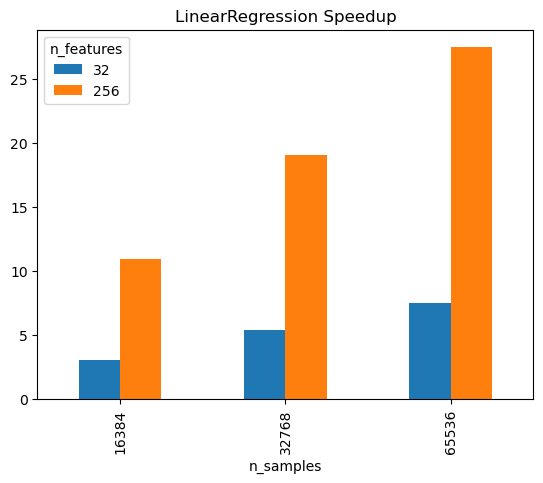

In [36]:
chart_single_algo_speedup(df, "LinearRegression")

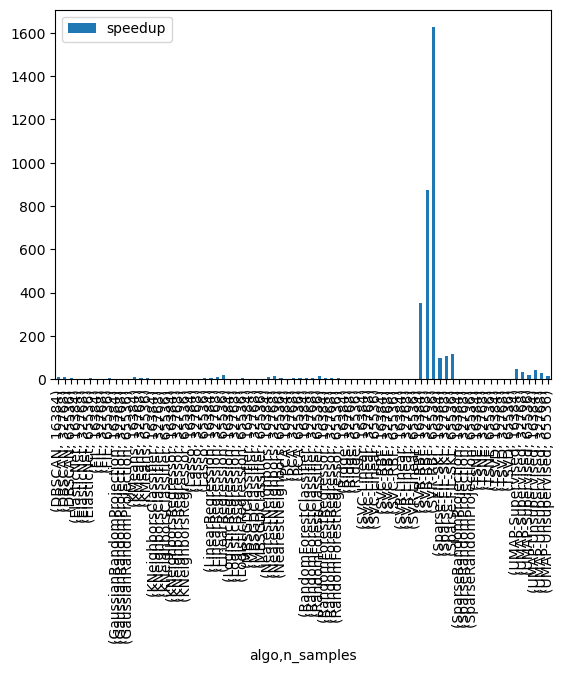

In [37]:
chart_all_algo_speedup(df)

### Output Results to CSV<a id="output_csv"/>

In [38]:
df.to_csv("benchmark_results.csv")